In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/char_transformer

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1ZdikWibndOy-EAHWOwKrJSalwWRmsckp/char_transformer


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import pandas as pd
import time

# local imports
import models.swiglu as swiglu
import util.generation as generation

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [3]:
key = jax.random.key(0)

# load the ./data/text8_train.txt and ./data/text8_test.txt files
with open("./data/text8_train.txt", "r") as f:
    train_text = f.read()
with open("./data/text8_test.txt", "r") as f:
    test_text = f.read()

# print the length of the training text and test text
print(f"Length of training text: {len(train_text):_} characters")
print(f"Length of test text: {len(test_text):_} characters")

Length of training text: 90_000_000 characters
Length of test text: 5_000_000 characters


In [4]:
# Build vocabulary (lowercase + space + a few punctuations)
char_set = list("abcdefghijklmnopqrstuvwxyz ")
char_to_int = {ch:i for i,ch in enumerate(char_set)}
int_to_char = {i:ch for ch,i in char_to_int.items()}

def encode(s):
    """Encode string to array of integers"""
    ids = [char_to_int[c] for c in s]
    return np.array(ids, dtype=np.uint8)  # use np.uint8 to save space

# encode the text
train_text_int = encode(train_text)
test_text_int = encode(test_text)

In [5]:
def create_train_state(
    model,
    rng=jax.random.key(0),
    vocab_size=27,
    d_model=64,
    n_layers=6,
    n_heads=8,
    max_len=128,
    dropout_rate=0.1,
):
    # instantiate model
    new_model = model(
        vocab_size=vocab_size,
        d_model=d_model,
        n_layers=n_layers,
        n_heads=n_heads,
        max_len=max_len,
        mlp_ratio = 8/3,
        tie_weights=True,
        dropout_rate=0.0,
    )

    # Dummy input for shape inference
    dummy = jnp.zeros((1, min(16, max_len)), dtype=jnp.int32)

    # Split RNGs: one for params, one for dropout (required even if deterministic=True)
    rng_params, rng_dropout = jax.random.split(rng)

    # Initialize parameters
    params = new_model.init(
        {"params": rng_params, "dropout": rng_dropout},
        dummy,
        deterministic=True  # no dropout during initialization
    )["params"]

    return new_model, params


In [6]:
# compute the number of parameters
def count_params(params):
    return sum(x.size for x in jax.tree_util.tree_leaves(params))

In [7]:
@jax.jit
def loss_and_metrics(logits, targets):
    """Compute cross-entropy loss and accuracy.

    Assumes `targets` contains only valid integer class ids in [0, V-1] (no -1 ignore tokens).

    Args:
      logits: (B, T, V) float array of unnormalized scores.
      targets: (B, T) integer array with ground-truth class ids.

    Returns:
      loss: scalar average cross-entropy over all positions.
      metrics: dict with keys "loss" and "acc" (both scalars).
    """
    # Flatten batch/time dims so optax works on shape (N, V) and (N,)
    # flat_logits = logits[:,-1, :]
    # flat_targets = targets[:,-1]
    # else:
    vocab = logits.shape[-1]
    flat_logits = logits.reshape(-1, vocab)
    flat_targets = targets.reshape(-1)

    # Per-position cross-entropy, then mean over all positions
    per_pos = optax.softmax_cross_entropy_with_integer_labels(flat_logits, flat_targets)
    loss = per_pos.mean()

    # prediction over all positions
    preds = jnp.argmax(logits, axis=-1)  # (B, T)

    # compute accuracy over only the last position
    is_match = preds == targets

    # Accuracy over all positions
    acc_all = jnp.mean(is_match.astype(jnp.float32))

    # Accuracy over only last position
    acc_last = jnp.mean(is_match.astype(jnp.float32)[:,-1])

    return loss, {"loss": loss, "acc": acc_all, "acc_last": acc_last}

In [8]:
# create an update function
def train_step(params, opt_state, x, y, rng, tx, model):
    rng, swiglu_rng = jax.random.split(rng)
    def loss_fn(params):
        logits = model.apply({"params": params}, x, deterministic=True)
        loss, metrics = loss_and_metrics(logits, y)
        return loss, metrics

    # compute gradients (loss is scalar, metrics is auxiliary)
    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # optax update: compute parameter updates and new optimizer state
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics

# jit: last argument should be static because it is an object
train_step = jax.jit(train_step, static_argnames=("tx", "model"))

In [9]:
# create a batch from the training data
def get_batch(text_int, B, T):
    """Create a random batch of data from text_int.

    Args:
      text_int: 1D array of token ids.
      B: batch size (number of sequences).
      T: sequence length (number of tokens per sequence).

    Returns:
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
    """
    # choose random starting indices for each sequence in the batch
    ix = np.random.randint(0, len(text_int) - T, size=B)
    # inputs are text from i to i+T
    x = np.stack([text_int[i:i+T] for i in ix])
    # targets are text from i+1 to i+T+1
    y = np.stack([text_int[i+1:i+T+1] for i in ix])
    return jnp.array(x, dtype=jnp.int32), jnp.array(y, dtype=jnp.int32)

In [10]:
# Create the optimizer
def create_optimizer(lr, params):
    tx = optax.adam(learning_rate=lr)
    opt_state = tx.init(params)
    return tx, opt_state

In [11]:
def train(model, params, rng=jax.random.key(0), lr=0.001, B=128, T=32, niter=10_000):
    tx, opt_state = create_optimizer(lr, params)
    loss_history = []
    time_history = []
    time_test_history = []
    loss_test_history = []
    acc_last_test_history = []
    time_start = time.time()
    for it in range(niter):
        batch = get_batch(train_text_int, B, T)
        input, target = batch[0], batch[1]
        params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, rng, tx, model)

        # update params and opt_state
        params = params_new
        opt_state = opt_state_new
        acc = metrics['acc']
        acc_last = metrics['acc_last']
        loss = metrics['loss']

        loss_history.append(loss)
        time_history.append(time.time() - time_start)

        if it % (niter // 50) == 0 or it == niter - 1:
            time_since_start = time.time() - time_start
            # compute loss on test set
            B_test, T_test = 1024, 32
            test_batch = get_batch(test_text_int, B_test, T_test)
            test_input, test_target = test_batch[0], test_batch[1]
            test_logits = None
            test_logits = model.apply({"params": params}, test_input, deterministic=True)
            test_loss, test_metrics = loss_and_metrics(test_logits, test_target)
            test_acc = test_metrics['acc']
            test_acc_last = test_metrics['acc_last']

            loss_test_history.append(test_loss)
            time_test_history.append(time_since_start)
            acc_last_test_history.append(test_acc_last)

            if it % (niter // 50) == 0 or it == niter - 1:
                print(f"iteration {it:_}  time: {time_since_start:.1f} seconds")
                print(f"\t \t loss(train :: test): {loss:.4f} :: {test_loss:.4f}")
                print(f"\t \t accuracy (train :: test): {100*acc:.1f}% :: {100*test_acc:.1f}%")
                print(f"\t \t accuracy (last character) (train :: test): {100*acc_last:.1f}% :: {100*test_acc_last:.1f}%")
                print()
    return loss_history, time_history, loss_test_history, time_test_history, acc_last_test_history, params


In [12]:
# Model Parameters
vocab_size= len(char_set)
d_model=256
n_heads=8
n_layers=3
max_len=128

swiglu_model, swiglu_model_params = create_train_state(
    swiglu.DecoderOnlyTransformer,
    key,
    vocab_size,
    d_model,
    n_layers,
    n_heads,
    max_len)

print(f"swiglu_wt_model_param_count: {count_params(swiglu_model_params):_}")


swiglu_wt_model_param_count: 2_405_884


In [13]:
swiglu_lr=0.00025
swiglu_B=256
swiglu_T=32
swiglu_niter=100_000

swiglu_loss_hist, swiglu_time_hist, swiglu_loss_test_hist, swiglu_time_test_hist, swiglu_acc_last_test_hist, swiglu_model_params = train(
    swiglu_model,
    swiglu_model_params,
    key,
    swiglu_lr,
    swiglu_B,
    swiglu_T,
    swiglu_niter
)

iteration 0  time: 9.2 seconds
	 	 loss(train :: test): 3.6997 :: 3.3232
	 	 accuracy (train :: test): 4.0% :: 14.2%
	 	 accuracy (last character) (train :: test): 3.9% :: 16.2%

iteration 2_000  time: 24.2 seconds
	 	 loss(train :: test): 1.4235 :: 1.4279
	 	 accuracy (train :: test): 56.0% :: 55.5%
	 	 accuracy (last character) (train :: test): 55.9% :: 56.8%

iteration 4_000  time: 31.7 seconds
	 	 loss(train :: test): 1.3729 :: 1.3730
	 	 accuracy (train :: test): 57.2% :: 56.9%
	 	 accuracy (last character) (train :: test): 58.2% :: 59.8%

iteration 6_000  time: 39.2 seconds
	 	 loss(train :: test): 1.3460 :: 1.3698
	 	 accuracy (train :: test): 58.0% :: 57.1%
	 	 accuracy (last character) (train :: test): 61.3% :: 59.0%

iteration 8_000  time: 46.7 seconds
	 	 loss(train :: test): 1.3210 :: 1.3399
	 	 accuracy (train :: test): 58.4% :: 58.3%
	 	 accuracy (last character) (train :: test): 59.4% :: 60.3%

iteration 10_000  time: 54.2 seconds
	 	 loss(train :: test): 1.3047 :: 1.349

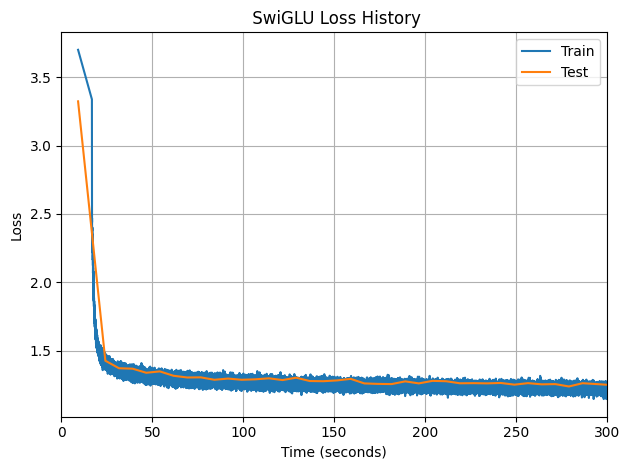

In [21]:
# plot the loss history
plt.plot(swiglu_time_hist, swiglu_loss_hist, label="Train")
plt.plot(swiglu_time_test_hist, swiglu_loss_test_hist, label="Test")
plt.xlabel("Time (seconds)")
plt.xlim(0, 300)
plt.ylabel("Loss")
plt.title(" SwiGLU Loss History")

plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("./assets/base_swiglu_scale_wt_loss_history.png")
plt.show()

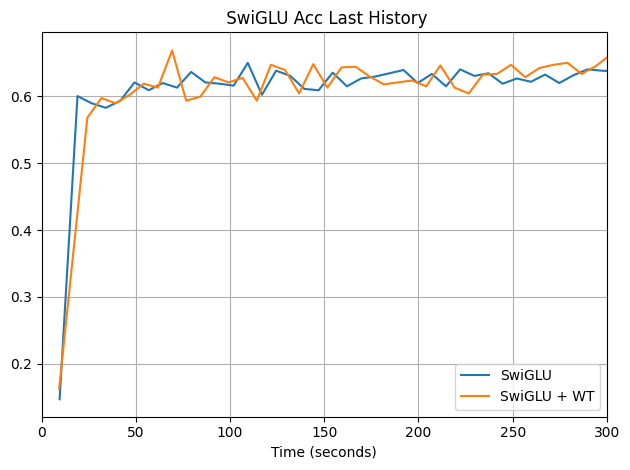

In [27]:
dat = pd.read_csv('./data/swiglu_scale_test_acc_last.csv')

# Plot the test accuracy on the last character
plt.plot(dat['time'], dat['loss'], label="SwiGLU")
plt.plot(swiglu_time_test_hist, swiglu_acc_last_test_hist, label="SwiGLU + WT")
plt.xlabel("Time (seconds)")
plt.title(" SwiGLU Acc Last History")
plt.xlim(0, 300)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [23]:

# Combine train and test losses if needed
swiglu_train_loss = np.array([swiglu_time_hist, swiglu_loss_hist]).T  # shape: (iterations, 2)
swiglu_test_loss = np.array([swiglu_loss_test_hist, swiglu_time_test_hist]).T  # shape: (iterations, 2)
swiglu_test_acc_last = np.array([swiglu_acc_last_test_hist, swiglu_time_test_hist]).T  # shape: (iterations, 2)

# Save losses to CSV
df_train_loss = pd.DataFrame(swiglu_train_loss, columns=['time', 'loss'])
df_train_loss.to_csv('./data/base_swiglu_scale_wt_train_loss.csv', index=False)

df_test_loss = pd.DataFrame(swiglu_test_loss, columns=['time', 'loss'])
df_test_loss.to_csv('./data/base_swiglu_scale_wt_test_loss.csv', index=False)

df_test_acc_last = pd.DataFrame(swiglu_test_acc_last, columns=['time', 'loss'])
df_test_acc_last.to_csv('./data/base_swiglu_scale_wt_test_acc_last.csv', index=False)

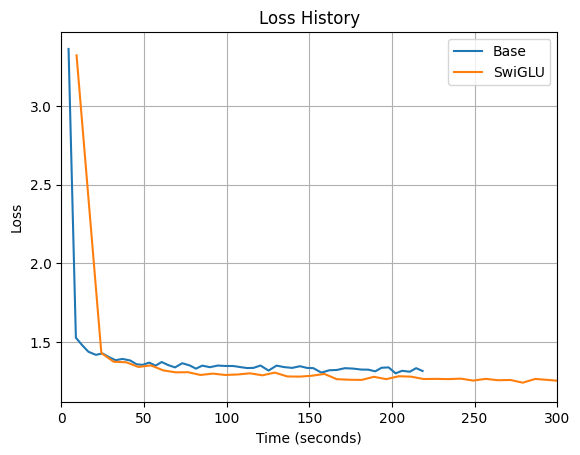

In [18]:
base_test_loss = pd.read_csv("./data/base_test_loss.csv")

plt.plot(base_test_loss['time'], base_test_loss['loss'], label="Base")
plt.plot(swiglu_time_test_hist, swiglu_loss_test_hist, label="SwiGLU")
plt.xlim(0, 300)
plt.legend()
plt.grid()
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.title("Loss History")

plt.show()
